- Name: Martha Kachweka

- Task: TBI Technical Test

### Abstract / Summary:

This project investigates binary classification techniques for distinguishing fake and real news using a text-based dataset spanning three domains: News, Politics, and Other.

The assignment aimed to build a machine learning model to detect and classify fake news articles. The dataset included labeled text samples of both real and fake news. To start, a set of **baseline models** such as **Logistic Regression and Naive Bayes** were used to establish reference performance levels. These models are simple but commonly used in text classification tasks, providing a solid benchmark for comparison.

To enhance model performance, several feature engineering techniques were applied. These included extracting the length of the news articles, counting words, punctuation marks (like exclamation and question marks), and detecting specific bias-related keywords. This step helped provide additional meaningful information beyond just the raw text.

After feature preparation, more advanced ensemble models such as **Random Forest**, **XGBoost**, and **LightGBM** were trained. These models are known for combining the predictions of multiple decision trees to improve accuracy and handle complex patterns in the data.

The results showed that while baseline models performed reasonably well, ensemble models outperformed them significantly. Both XGBoost and LightGBM achieved over **99%** accuracy, indicating strong model generalization and effectiveness in identifying fake news. The project demonstrates the power of combining thoughtful feature design with advanced modeling techniques to tackle misinformation.

# Library Installation

In [1]:
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack

# import shap

warnings.filterwarnings("ignore")


# Loading and reading the datasets

In [2]:
# loading both dataset
fake_df = pd.read_csv('Fake.csv')
real_df = pd.read_csv('True.csv')

# Exploratory data analysis (EDA)

In [3]:
#checking for the fist 5 rows of the fake news dataset
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
#checking for the fist 5 rows of the real news dataset

real_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
#checking the data information:

print("Fake News Dataset Info:")
fake_df.info()
print("\nReal News Dataset Info:")
real_df.info()

Fake News Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB

Real News Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [6]:
#checking for the null values:
print("Fake News Dataset Null Values:")
print(fake_df.isnull().sum())
print(".......................... ")
print("\nReal News Dataset Null Values:")
print(real_df.isnull().sum())

Fake News Dataset Null Values:
title      0
text       0
subject    0
date       0
dtype: int64
.......................... 

Real News Dataset Null Values:
title      0
text       0
subject    0
date       0
dtype: int64


## Visualization

Checking the distribution of both fake and real news datasets using graph visualization 


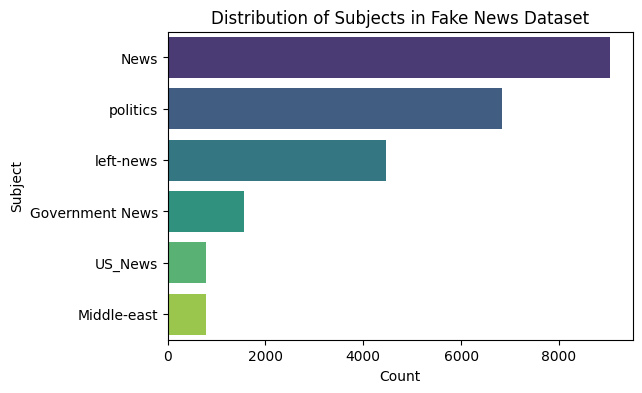

In [7]:
plt.figure(figsize=(6, 4))
sns.barplot(x=fake_df['subject'].value_counts().values,y=fake_df['subject'].value_counts().index,palette='viridis')
plt.title('Distribution of Subjects in Fake News Dataset')
plt.xlabel('Count')
plt.ylabel('Subject')
plt.show()

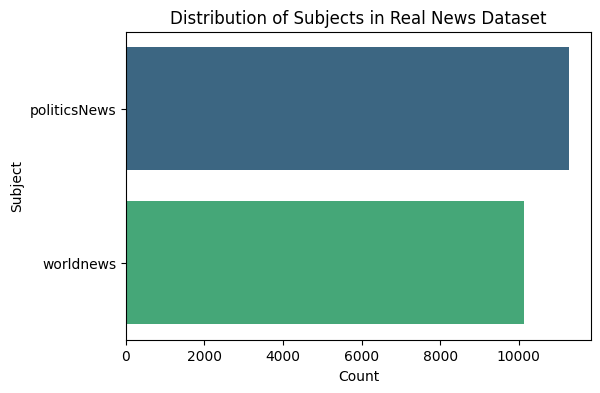

In [8]:
plt.figure(figsize=(6, 4))
sns.barplot(x=real_df['subject'].value_counts().values,y=real_df['subject'].value_counts().index,palette='viridis')
plt.title('Distribution of Subjects in Real News Dataset')
plt.xlabel('Count')
plt.ylabel('Subject')
plt.show()


**Distribution Insights:**

The dataset in fake news, comprises multiple news categories. A distribution analysis in the image above revealed that the majority of articles fall under "News" and "Politics", followed by "Left-news". Other categories such as "Government News", "US_News", and "Middle-east" are underrepresented, potentially leading to model bias toward dominant categories.

On the other hand, the distribution in real news indicate that politicsNews exceeds the worldnews

##### Map the subjects into their domains; (News, Politics, and Others)

##### 1. Fake dataset:

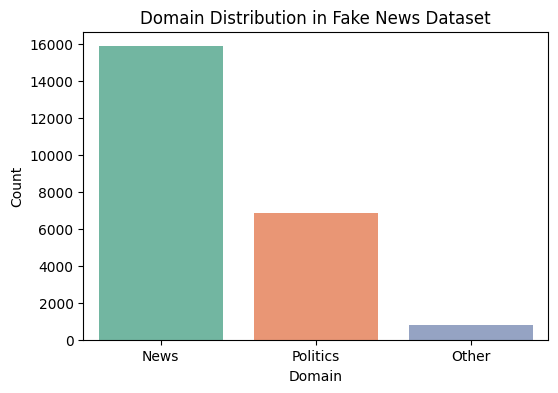

In [9]:
def map_subject(subject):
    subject_lower = subject.lower()
    if 'politics' in subject_lower:
        return 'Politics'
    elif 'news' in subject_lower:
        return 'News'
    else:
        return 'Other'
fake_df['domain'] = fake_df['subject'].apply(map_subject)


"""Domain distribution of the fake news dataset"""

plt.figure(figsize=(6, 4))
sns.countplot(data=fake_df, x='domain', palette='Set2')
plt.title('Domain Distribution in Fake News Dataset')
plt.xlabel('Domain')
plt.ylabel('Count')
plt.show()

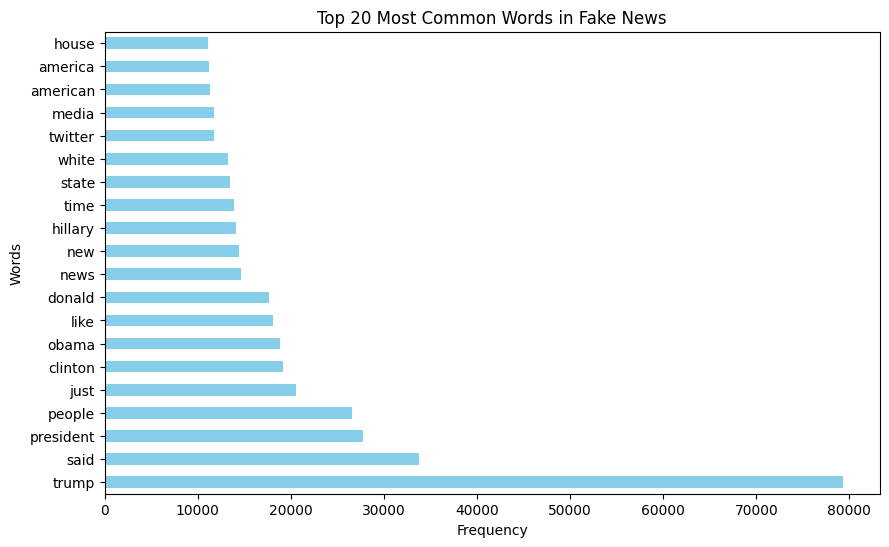

In [10]:
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(fake_df['text'])
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
top_words = word_freq.sum().sort_values(ascending=False)

top_words.head(20).plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title('Top 20 Most Common Words in Fake News')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

##### To standardize subject representation, a function was applied to categorize each article into three broader domains: "News", "Politics", and "Other"; the News category surpases both political and others with over 14,000 information . This was done by mapping the original subject labels based on keyword matching: And top 20 most common words in Fake news were indicated, however, the word trump ws most common word with 0ver **7000** words

#### 2. Real news

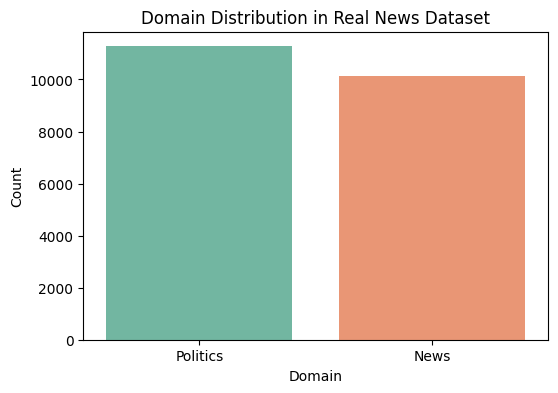

In [11]:
def map_subject(subject):
    subject_lower = subject.lower()
    if 'politics' in subject_lower:
        return 'Politics'
    elif 'news' in subject_lower:
        return 'News'
    else:
        return 'Other'
real_df['domain'] = real_df['subject'].apply(map_subject)


"""Domain distribution of the real news dataset"""

plt.figure(figsize=(6, 4))
sns.countplot(data=real_df, x='domain', palette='Set2')
plt.title('Domain Distribution in Real News Dataset')
plt.xlabel('Domain')
plt.ylabel('Count')
plt.show()

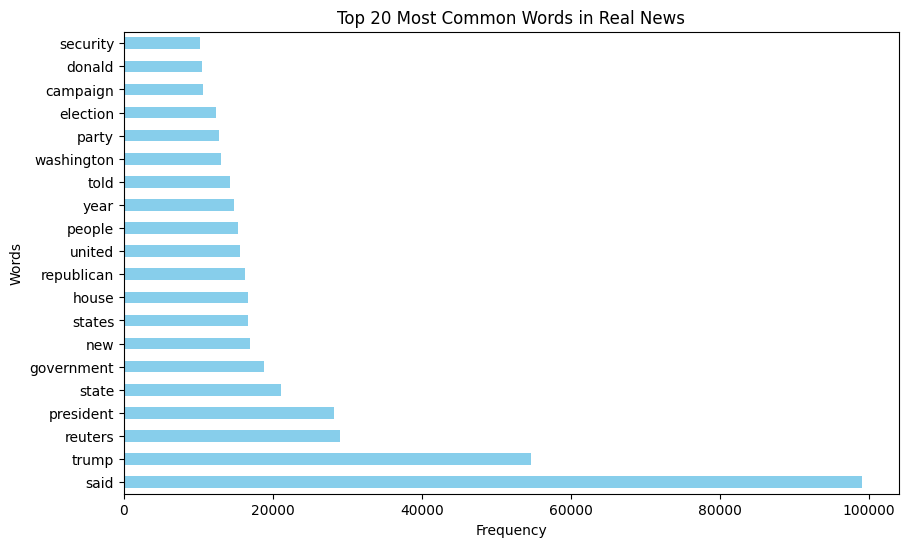

In [12]:

vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(real_df['text'])
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
top_words = word_freq.sum().sort_values(ascending=False)

top_words.head(20).plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title('Top 20 Most Common Words in Real News')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

Moving to Real news, it had only two category which were news and politics. However, the politics had over 10,000 informations compared to news. Additionally, In most common words, the word **said** appeared 98,000 times exceeding towards 100,000. 

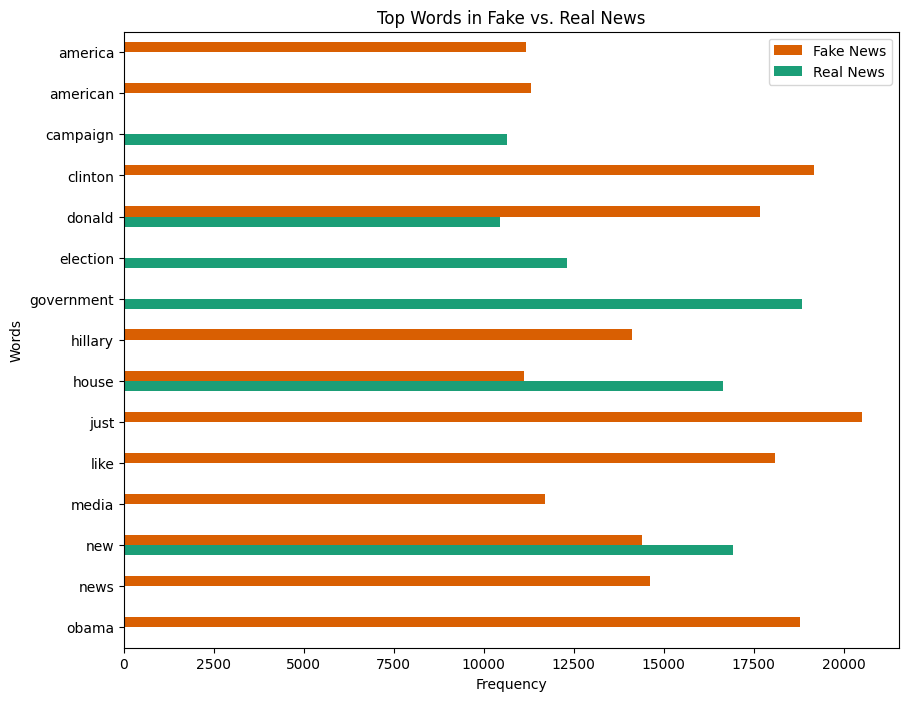

In [13]:
# comparing both news (Fake and Real):
def get_top_words(df, n=20):
    vectorizer = CountVectorizer(stop_words='english', max_features=n)
    X = vectorizer.fit_transform(df['text'])
    word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum()
    return word_freq.sort_values(ascending=False)

top_fake_words = get_top_words(fake_df)
top_real_words = get_top_words(real_df)

comparison = pd.DataFrame({'Fake': top_fake_words,'Real': top_real_words})

comparison.head(15).plot(kind='barh', figsize=(10, 8), color=['#d95f02', '#1b9e77'])
plt.title('Top Words in Fake vs. Real News')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.legend(['Fake News', 'Real News'])
plt.gca().invert_yaxis() 
plt.show()

comparative analysis of word frequency between fake and real news articles reveals distinct patterns in language usage. Fake news articles frequently employ emotionally charged or personalized terms like "**hillary**," "**obama**," "**clinton**," "**just**," "**like**," and "**media**," which appear in contexts suggesting bias and opinion-based narratives. In contrast, real news articles predominantly use institutional and factual language, featuring terms such as "**government**," "**campaign**," "**election**," and "**house**," which reflects a more formal and policy-focused approach. Some terms, including "**donald**" and "**new**," appear frequently across both fake and real news categories, indicating shared topic coverage. 
The analysis shows that fake news is characterized by emotionally evocative vocabulary, while real news tends to use political and governmental terminology.


In [14]:
"""creating a new column called 'label' to identify the type of news.
0 for fake news and 1 for real news."""

fake_df['label'] = 0
real_df['label'] = 1


combined_new= pd.concat([fake_df, real_df], ignore_index=True)
combined_new = combined_new[['text', 'subject', 'label']].dropna().reset_index(drop=True)


Text(0.5, 1.0, 'Distribution of Subjects in Combined News Dataset')

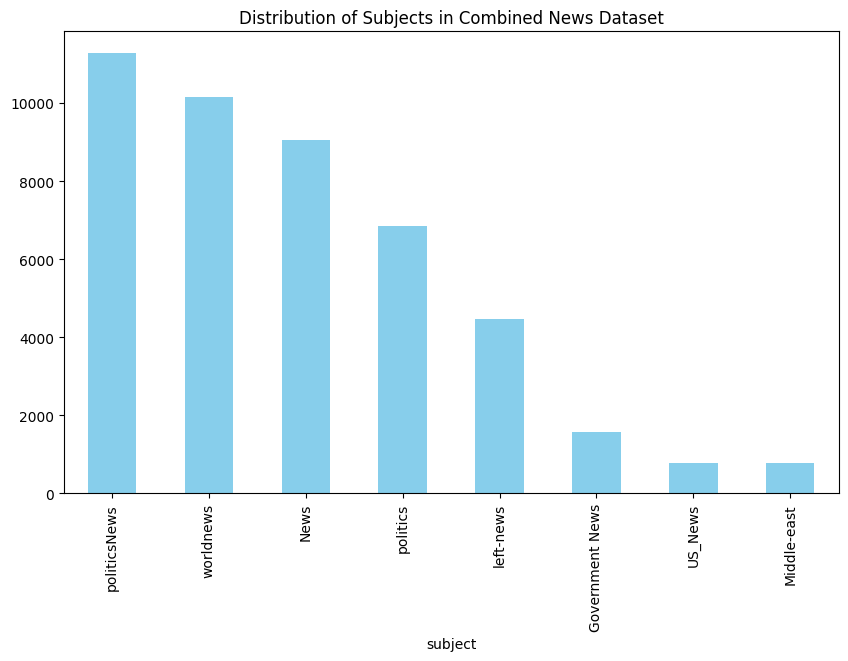

In [15]:
combined_new['subject'].value_counts().plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Distribution of Subjects in Combined News Dataset')  

In [16]:
def map_subject(subject):
    subject_lower = subject.lower()
    
    if 'politics' in subject_lower:
        return 'Politics'
    elif 'news' in subject_lower:
        return 'News'
    else:
        return 'Other'

# applying the function
combined_new['subject'] = combined_new['subject'].apply(map_subject)

# Check the result
combined_new['subject'].value_counts()

subject
News        26007
Politics    18113
Other         778
Name: count, dtype: int64

In [17]:
print(combined_new.isna().sum()) #checking for the null values in the combined dataset

text       0
subject    0
label      0
dtype: int64


 ### Baseline Model

In [18]:
# binary classification: will classify the news into two categories fake = 0, real= 1

X = combined_new['text']
y = combined_new['label']  

X_train, X_test, y_train, y_test, subj_train, subj_test = train_test_split(X, y, combined_new['subject'],test_size=0.2, stratify=y, random_state=42)


In [19]:
# build a pipeline
pipeline = Pipeline([ ('tfidf', TfidfVectorizer(stop_words='english', max_features=10000)),('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))])

# train
pipeline.fit(X_train, y_train)

# predict
y_pred = pipeline.predict(X_test)

# overall evaluation
print("Overall Performance:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Overall Performance:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4696
           1       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Accuracy: 0.9859688195991091


The metrics demonstrate that the model achieves balanced performance between precision and recall across both fake and real label classifications. The logistic regression model exhibits nearly identical performance levels when detecting both fake and real content. The high F1-score obtained indicates the model's overall strength and reliability, positioning logistic regression as a solid baseline approach for fake news detection tasks.

In [20]:
# domains = subj_test.unique()
# for domain in domains:
#     idx = subj_test == domain
#     print(f"\nPerformance in domain: {domain}")
#     print("Precision:", precision_score(y_test[idx], y_pred[idx]))
#     print("Recall:", recall_score(y_test[idx], y_pred[idx]))
#     print("F1 Score:", f1_score(y_test[idx], y_pred[idx]))

In [21]:
domains = subj_test.unique()

for domain in domains:
    mask = subj_test == domain
    y_true_d = y_test[mask]
    y_pred_d = y_pred[mask]

    # acc = accuracy_score(y_true_d, y_pred_d)
    prec = precision_score(y_true_d, y_pred_d)
    rec = recall_score(y_true_d, y_pred_d)
    f1 = f1_score(y_true_d, y_pred_d)


    print(f"\nDomain Performance: {domain}")
    # print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1 Score : {f1:.4f}")


Domain Performance: Politics
  Precision: 0.9841
  Recall   : 0.9841
  F1 Score : 0.9841

Domain Performance: News
  Precision: 0.9793
  Recall   : 0.9962
  F1 Score : 0.9877

Domain Performance: Other
  Precision: 0.0000
  Recall   : 0.0000
  F1 Score : 0.0000



- The model demonstrates strong performance in the Politics domain, showing effective capture of linguistic and structural patterns typical in political articles, with high precision and recall indicating minimal false positives and negatives.

- For the News domain, the model shows exceptional recall by successfully identifying most real/fake news examples, though slightly lower precision suggests some false positives. The F1 Score remains high overall.

- The model's performance in the "Other" domain shows poor generalization, likely due to:
    <ul>
    
        - Limited sample size

        - Heterogeneous content differing from training distribution

        - Need for additional examples or domain-specific fine-tuning
    </ul>


In [22]:
import numpy as np

# TF-IDF feature names
vectorizer = pipeline.named_steps['tfidf']
clf = pipeline.named_steps['clf']
feature_names = vectorizer.get_feature_names_out()

# top number of features for each class
top_n = 5
coefs = clf.coef_[0]
top_fake = np.argsort(coefs)[:top_n]
top_real = np.argsort(coefs)[-top_n:]

print("\nTop predictors of FAKE news:")
for i in top_fake:
    print(f"{feature_names[i]}: {coefs[i]:.4f}")

print("\nTop predictors of REAL news:")
for i in reversed(top_real):
    print(f"{feature_names[i]}: {coefs[i]:.4f}")



Top predictors of FAKE news:
read: -6.1563
just: -6.0276
image: -5.7477
featured: -5.7014
gop: -5.2652

Top predictors of REAL news:
reuters: 28.0992
said: 17.8010
washington: 6.6954
wednesday: 5.5133
thursday: 5.0981


This analysis shows that fake news tends to rely on emotionally persuasive or vague language, while real news emphasizes concrete details, sources, 
and timelines. 

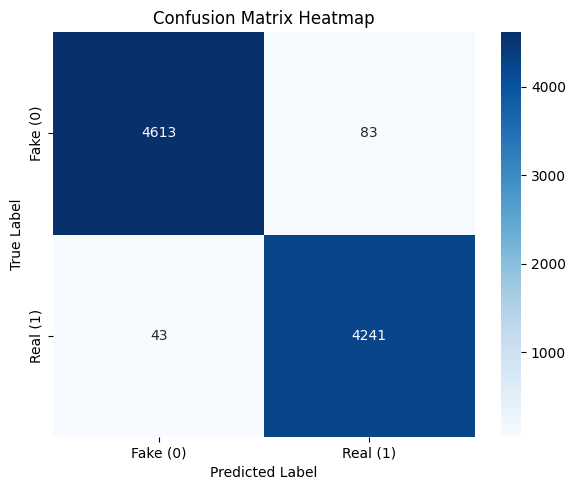

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Optional: define labels
labels = ['Fake (0)', 'Real (1)']

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()


**Interpretation:**
- True Positives (TP - Real predicted as Real): 4241

- True Negatives (TN - Fake predicted as Fake): 4613

- False Positives (FP - Fake predicted as Real): 83

- False Negatives (FN - Real predicted as Fake): 43

**Insight:**
- The model shows strong predictive power, correctly identifying the majority of both fake and real news articles.

- Only 83 fake articles were incorrectly classified as real, while 43 real articles were misclassified as fake.

- These low error rates indicate the model has high precision and recall, which was also reflected in the earlier metrics (F1 ≈ 0.99).

- The slight imbalance in misclassifications suggests a marginal tendency to favor identifying fake news more cautiously, which could be beneficial in minimizing false trust in misinformation.



### Step 2

**Step 2:** is about model improvement to make model performs better; here we includes the dataset from kaggle which consists of only politic fake and real news. politics news were considered, why? because based on the previous dataset it contains alot of information. There after we combined the new dataset with the previous dataset (combined_new) and **combined_df** had all datasets ready for model evaluation

*Source:*
[Fake news (PolitiFact & BuzzFeed):](https://www.kaggle.com/datasets/sohaila103/fake-news-politifact-and-buzzfeed)

In [24]:
politic_fake_df = pd.read_csv('PolitiFact_fake_news_content.csv', encoding='latin1')
politic_real_df = pd.read_csv('PolitiFact_real_news_content.csv', encoding='latin1')    

In [25]:
politic_fake_df .tail()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data
206,Fake_88-Webpage,Hillarys TOP Donor Country Just Auctioned Off...,Hillarys TOP Donor Country Just Auctioned Off...,http://rightwingnews.com/hillary-clinton-2/hil...,http://rightwingnews.com/wp-content/uploads/20...,Terresa Monroe-hamilton,http://rightwingnews.com,{'$date': 1474912025000},NaN,http://1.gravatar.com/avatar/d35b77ff6c3900715...,http://rightwingnews.com/hillary-clinton-2/hil...,"{""googlebot"": ""noimageindex"", ""og"": {""site_nam..."
207,Fake_89-Webpage,Cavuto Just Exposed Lester Holt's Lies During ...,Advertisement - story continues below\n\nThe f...,http://conservativetribune.com/lester-holt-lie...,http://conservativetribune.com/wp-content/uplo...,"Martin Lioll,John Falkenberg,Ben Marquis,Kimbe...",http://conservativetribune.com,{'$date': 1474934400000},https://www.youtube.com/embed/ThwaDSaoGU8?feat...,http://conservativetribune.com/wp-content/uplo...,http://conservativetribune.com/lester-holt-lie...,"{""description"": ""People are already calling th..."
208,Fake_9-Webpage,"The AP, In 2004, Said Your Boy Obama Was BORN ...",Well THATS Weird. If the Birther movement is ...,http://clashdaily.com/2016/09/dear-cnn-ap-2004...,http://clashdaily.com/wp-content/uploads/2016/...,"Rich Witmer,Doug Giles",http://clashdaily.com,{'$date': 1474207108000},NaN,http://clashdaily.wpengine.netdna-cdn.com/wp-c...,http://clashdaily.com/2016/09/dear-cnn-ap-2004...,"{""googlebot"": ""noimageindex"", ""og"": {""site_nam..."
209,Fake_90-Webpage,People Noticed Something Odd About Hillary's O...,\n\nTheres a lot to be discussed about last n...,http://www.thepoliticalinsider.com/first-presi...,http://assets.thepoliticalinsider.com.s3.amazo...,NaN,http://www.thepoliticalinsider.com,{'$date': 1475000011000},NaN,http://1.gravatar.com/avatar/71be986d321b3d520...,http://thepoliticalinsider.com/first-president...,"{""description"": ""One thing that has baffled ma..."
210,Fake_91-Webpage,People Noticed Something Odd About Hillarys O...,People Noticed Something Odd About Hillarys O...,http://rightwingnews.com/top-news/people-notic...,http://rightwingnews.com/wp-content/uploads/20...,Lisa Smith,http://rightwingnews.com,{'$date': 1475010040000},NaN,http://0.gravatar.com/avatar/3728144c20aefded7...,http://rightwingnews.com/top-news/people-notic...,"{""googlebot"": ""noimageindex"", ""og"": {""site_nam..."


In [26]:
#keep only 'text', 'title', and 'label'
politic_real_df = politic_real_df[['text', 'title']]

#rename 'title' column to 'subject'
politic_real_df = politic_real_df.rename(columns={'title': 'subject'})


In [27]:
#keep only 'text', 'title', and 'label'
politic_fake_df = politic_fake_df[['text', 'title']]

#rename 'title' column to 'subject'
politic_fake_df = politic_fake_df.rename(columns={'title': 'subject'})


In [28]:
# assigning labels to the datasets
# 0 for fake news and 1 for real news
politic_fake_df['label'] = 0
politic_real_df['label'] = 1

In [29]:
#checking for the null values in the politic fake news dataset
politic_real_df.isna().sum()

text       0
subject    0
label      0
dtype: int64

In [30]:
#checking for the null values in the politic real news dataset
politic_fake_df.isna().sum()

text       0
subject    0
label      0
dtype: int64

In [31]:
# combining two datasets and using only 'text', 'subject', and 'label' columns

new_data= pd.concat([politic_fake_df, politic_real_df], ignore_index=True)
new_data = new_data[['text', 'subject', 'label']].dropna().reset_index(drop=True)

In [32]:
# converting the text to lowercase 
new_data['text'] = new_data['text'].str.lower()

In [33]:
# since the dataset is about politics, assign the subject as 'Politics'
new_data['subject'] = 'Politics'

In [34]:
# concatenating the new dataset with the combined dataset

combined_df= pd.concat([combined_new, new_data], axis=0).drop_duplicates().reset_index(drop=True)

In [35]:
combined_df.tail()

,text,subject,label
43898,"like much of the mainstream media, the washing...",Politics,1
43899,2016 obamas team isnt laughing at trump anym...,Politics,1
43900,"story highlights trump has 45%, clinton 42% an...",Politics,1
43901,there may be a few women out there who enjoy a...,Politics,1
43902,off message is donald trump qualified to be pr...,Politics,1


###  **Feature Engineering**

***Abstract:***

To help the model better tell the difference between fake and real news, we added some helpful features (extra information) to the dataset. These features are based on how the text is written and what words or symbols it uses. The main techniques used were:

- ***Text Length and Word Count:***

We looked at how long each article is and how many words it contains. Fake news might be too short or too long compared to real news.

- ***Punctuation Marks:***

We counted things like exclamation marks (!) and question marks (?) to check if the article sounds dramatic or emotional. Fake news often uses these more to attract attention.

- ***Keyword Check:***

We searched for certain words that are often found in fake news, like “shocking” or “breaking.” These words can signal biased or misleading content.

After creating these features, we used a tool called ColumnTransformer to prepare the data:

- It turned the text into a format the model can understand using something called TF-IDF (it looks at how important words are).

- It also scaled the numbers (like word count) so they are easier to compare.

All these features were combined into X (what the model learns from), and the label (whether the article is fake or real) was kept as y (what the model tries to predict).



In [36]:
#text Length and word count

combined_df['text_length'] = combined_df['text'].str.len()
combined_df['word_count'] = combined_df['text'].str.split().apply(len)


In [37]:
# punctuation-based features

combined_df['exclamation_count'] = combined_df['text'].str.count('!')
combined_df['question_count'] = combined_df['text'].str.count('\?')


In [38]:
# simple keyword check

bias_words = ['shocking', 'hoax', 'breaking', 'miracle', 'secret', 'conspiracy']

combined_df['bias_word_count'] = combined_df['text'].apply(
    lambda x: sum(word in x.lower() for word in bias_words)
)


In [39]:
combined_df.head()

,text,subject,label,text_length,word_count,exclamation_count,question_count,bias_word_count
0,Donald Trump just couldn t wish all Americans ...,News,0,2893,495,6,9,1
1,House Intelligence Committee Chairman Devin Nu...,News,0,1898,305,0,0,0
2,"On Friday, it was revealed that former Milwauk...",News,0,3597,580,2,4,2
3,"On Christmas day, Donald Trump announced that ...",News,0,2774,444,0,1,0
4,Pope Francis used his annual Christmas Day mes...,News,0,2346,420,0,0,0


In [40]:
preprocessor = ColumnTransformer([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english'), 'text'),
    ('num', StandardScaler(), ['text_length', 'word_count', 'exclamation_count', 'question_count', 'bias_word_count']),
    ('subject', OneHotEncoder(handle_unknown='ignore'), ['subject'])
])


In [41]:
X = combined_df[['text', 'text_length', 'word_count', 'exclamation_count', 'question_count', 'bias_word_count', 'subject']]
y = combined_df['label']


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


### Different Model Architectures

To identify whether a news article is fake or real, two types of machine learning models were tested: Naive Bayes and Random Forest.

- Naive Bayes is a simple model that works well with text by calculating probabilities of words.

- Random Forest is a more advanced model that uses many decision trees to make better predictions.

Both models were trained on the same dataset and evaluated based on how accurately they could predict fake or real news.

***Results:***

- Random Forest performed best, achieving 99% accuracy, with very high precision and recall for both fake and real news.

- Naive Bayes was simpler but still effective, reaching 92% accuracy.

These results show that while Naive Bayes offers a fast and simple solution, Random Forest provides stronger and more reliable predictions, making it more suitable. 

#### a. Naive Bayes

In [43]:

nb_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),('nb', MultinomialNB())])

nb_pipeline.fit(X_train['text'], y_train)
nb_preds = nb_pipeline.predict(X_test['text'])

print("Naive Bayes Performance:")
print("Accuracy:", accuracy_score(y_test, nb_preds))
print(classification_report(y_test, nb_preds))



Naive Bayes Performance:
Accuracy: 0.9242683065710056
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      4500
           1       0.93      0.92      0.92      4281

    accuracy                           0.92      8781
   macro avg       0.92      0.92      0.92      8781
weighted avg       0.92      0.92      0.92      8781



#### b. Random Forest

In [44]:

rf_pipeline = Pipeline([('preprocess', preprocessor),('clf', RandomForestClassifier(n_estimators=100, random_state=42))])

rf_pipeline.fit(X_train, y_train)
rf_preds = rf_pipeline.predict(X_test)

print("Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))


Random Forest Performance:
Accuracy: 0.9918004783054322
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4500
           1       0.99      0.99      0.99      4281

    accuracy                           0.99      8781
   macro avg       0.99      0.99      0.99      8781
weighted avg       0.99      0.99      0.99      8781



### Ensemble Models

- The ensemble learning models **LightGBM** and **XGBoost** were used to classify news articles as either fake or real. These models combine the predictions of many decision trees to make more accurate and stable predictions.

- **LightGBM** achieved an accuracy of 99.36%, with balanced precision, recall, and F1-score across both classes. It is well known for its speed and ability to handle large datasets efficiently.

- While the **XGBoost** slightly outperformed LightGBM with an accuracy of 99.41%. This model is highly optimized for performance and delivered consistent results with strong precision and recall.

In conclusion, both models demonstrated excellent ability to learn complex patterns in the text data, confirming the value of ensemble methods in fake news detection.

#### a. LightGBM Model

In [45]:
from sklearn.pipeline import Pipeline

lgbm_pipeline = Pipeline([('preprocess', preprocessor),('clf', LGBMClassifier())])

lgbm_pipeline.fit(X_train, y_train)
lgbm_preds = lgbm_pipeline.predict(X_test)

print("LightGBM Performance:")
print("Accuracy:", accuracy_score(y_test, lgbm_preds))
print(classification_report(y_test, lgbm_preds))


[LightGBM] [Info] Number of positive: 17125, number of negative: 17997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.479131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 801205
[LightGBM] [Info] Number of data points in the train set: 35122, number of used features: 5007
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.487586 -> initscore=-0.049666
[LightGBM] [Info] Start training from score -0.049666
LightGBM Performance:
Accuracy: 0.9913449493224007
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4500
           1       0.99      0.99      0.99      4281

    accuracy                           0.99      8781
   macro avg       0.99      0.99      0.99      8781
weighted avg       0.99      0.99      0.99      8781



#### b. XGBoost Model

In [46]:
xgb_pipeline = Pipeline([('preprocess', preprocessor),
            ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

xgb_pipeline.fit(X_train, y_train)
xgb_preds = xgb_pipeline.predict(X_test)

print("XGBoost Performance:")
print("Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))


XGBoost Performance:
Accuracy: 0.991003302585127
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4500
           1       0.99      0.99      0.99      4281

    accuracy                           0.99      8781
   macro avg       0.99      0.99      0.99      8781
weighted avg       0.99      0.99      0.99      8781

